# Image Classification in `PyTorch`.

In this notebook, we are going to develop a neural network model for classify images from the Fashion-MNIST dataset.

In [100]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np 
import matplotlib.pyplot as plt
import time
import random
import itertools
from sklearn import metrics

## 1. Load and visualise the data.

The dataset is prepared in a similar way to MNIST. It is split into a set of 60,000 training images and a set of 10,000 test images. The images are of size 28x28 pixels.

There are 10 label classes in total, which are:
* 0: T-shirt/top
* 1: Trousers
* 2: Pullover
* 3: Dress
* 4: Coat
* 5: Sandal
* 6: Shirt
* 7: Sneaker
* 8: Bag
* 9: Ankle boot

In [128]:
# Load data
train_set = torchvision.datasets.FashionMNIST(root='.', download=True, train=True)
train_image = np.array(train_set.data)
train_label = np.array(train_set.targets)
class_name = train_set.classes
print(f"List of class names: {class_name}")

test_set = torchvision.datasets.FashionMNIST(root='.', download=True, train=False)
test_image = np.array(test_set.data)
test_label = np.array(test_set.targets)

List of class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


### Display the dimension of the training and test sets.

In [55]:
print(f"The shape of train_image is {train_image.shape}")
print(f"The shape of train_label is {train_label.shape}")
print(f"The shape of test_image is {test_image.shape}")
print(f"The shape of test_label is {test_label.shape}")

The shape of train_image is (60000, 28, 28)
The shape of train_label is (60000,)
The shape of test_image is (10000, 28, 28)
The shape of test_label is (10000,)


### Visualise sample images from the dataset with their respective labels.

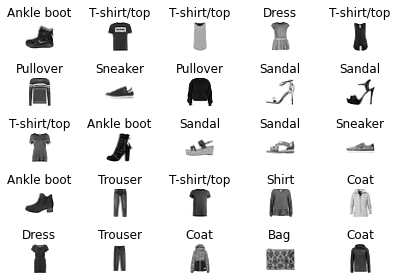

In [111]:
num_rows = 5
num_cols = 5
num_images = num_rows * num_cols
for i in range(num_images):
    plt.subplot(num_rows,num_cols,i+1)
    plt.imshow(train_image[i], cmap='binary')
    plt.axis("off")
    plt.title(class_name[train_label[i]])
plt.tight_layout()
plt.show()

### Display the number of training samples for each class.

In [61]:
_ , counts = np.unique(train_label, return_counts = True)
dictionary = dict(zip(class_name, counts))
print(f"The number of training samples for each class is {dictionary}.")

The number of training samples for each class is {'T-shirt/top': 6000, 'Trouser': 6000, 'Pullover': 6000, 'Dress': 6000, 'Coat': 6000, 'Sandal': 6000, 'Shirt': 6000, 'Sneaker': 6000, 'Bag': 6000, 'Ankle boot': 6000}.


## 2. Creating and evaluating a Convolutional Neural Network model.

### Obtain a GPU device for training, otherwise use a CPU.

In [62]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using a {device} device for training.")

Using a cpu device for training.


### Build a convolutional neural network using the `PyTorch` library to perform classification on the Fashion-MNIST dataset.

In [19]:
class ConvNN(nn.Module):
    def __init__(self):
        """
        A convolutional neural network whose pipeline is very similar to that of LeNet.
        
        It initially pads the 28x28 input image (of 1 channel) with a padding of 2
        to replicate the C1 output of LeNet (i.e it returns 6 28x28 feature maps).
        
        Note that the softmax activation function is not applied to the final 10 inputs 
        into the final layer because the CrossEntropyLoss() function used later 
        combines nn.LogSoftmax() and nn.NLLLoss() (negative log likelihood loss) in one go,
        that is, the CrossEntropyLoss() function will apply the softmax activation function 
        to these inputs and thus create an output vector of probabilites that will classify
        the input image(s).
        """
        super(ConvNN, self).__init__()
        
        # Note that the input to layer1 will be 1 feature map of size 28x28
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, stride = 1, padding = 2),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 0),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = 5, stride = 1, padding = 0)
        )
        
        # Use dropout in order to avoid overfitting to the training data.
        self.dropout = nn.Dropout()
        
        self.fc1 = nn.Linear(in_features = 120, out_features = 84)
        self.fc2 = nn.Linear(in_features = 84, out_features = 10)
        
    def forward(self, x):
        """
        Runs an input matrix of features through the Convolutional Neural Network
        and returns a vector of size 10x1 which will be used after the CrossEntropyLoss()
        function is applied (later) to classify each input image.
        """
        out = self.layer1(x)
        out = self.layer2(out)
        # The output will be 120 feature maps of size 1x1, we reshape it to be a 120 dimensional vector ready
        # for input into the nn.Linear layer.
        out = out.reshape(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.fc2(out)

        return out

### Instantiate a ConvNN and print the model architecture.

In [63]:
convNet = ConvNN().to(device)
print(convNet)

ConvNN(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


### Define the loss function, optimiser and hyper-parameters used for training the model.

In [64]:
# Set the hyperparameters
epochs = 5
classes = 10
batch_size = 100
learning_rate = 0.001

# Loss Function:
loss_function = nn.CrossEntropyLoss()

# Optimiser:
optimiser = optim.Adam(convNet.parameters(), lr = learning_rate)

### Start model training.

At each iteration, get a random batch of images and labels from train_image and train_label, convert them into torch tensors, feed into the network model and perform gradient descent. Please also evaluate how long it takes for training.

In [22]:
start = time.time()

#Calculate the number of iterations per epoch:
num_of_iterations = train_label.shape[0]//batch_size

#Arrays to be used in printing later.
loss_list = []
accuracy_list = []

for epoch in range(epochs):
    #Randomise the train_image and train_labels
    randomise = np.arange(len(train_image))
    np.random.shuffle(randomise)
    train_image_shuffled = train_image[randomise]
    train_label_shuffled = train_label[randomise]
    
    for i in range(num_of_iterations):
        #Take each cut for the images and labels and turn them into tensors.
        train_image_cut = train_image_shuffled[(i*batch_size):((i+1)*batch_size)]
        train_image_cut = np.expand_dims(train_image_cut, axis=1)
        train_label_cut = train_label_shuffled[(i*batch_size):((i+1)*batch_size)]
        
        train_image_cut_tensor = torch.from_numpy(train_image_cut)
        train_image_cut_tensor = train_image_cut_tensor.type(torch.float32)
        train_label_cut_tensor = torch.from_numpy(train_label_cut)
    
        #Pass them through the CNN and update the weights based on the optimiser.
        optimiser.zero_grad()
        outputs = convNet(train_image_cut_tensor)
        loss = loss_function(outputs, train_label_cut_tensor)
        loss.backward()
        optimiser.step()
    
        #Calculate the accuracy statistics.
        total = train_label_cut_tensor.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == train_label_cut_tensor).sum().item()
        accuracy_list.append(correct / total)
        
        #Print the Loss and Accuracy at the end of each epoch.
        if (i + 1) % num_of_iterations == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, epochs, i + 1, num_of_iterations, loss.item(),
                          (correct / total) * 100))
            
end = time.time()
print("Time:", end - start)

Epoch [1/5], Step [600/600], Loss: 0.7147, Accuracy: 77.00%
Epoch [2/5], Step [600/600], Loss: 0.4496, Accuracy: 87.00%
Epoch [3/5], Step [600/600], Loss: 0.4638, Accuracy: 87.00%
Epoch [4/5], Step [600/600], Loss: 0.4753, Accuracy: 84.00%
Epoch [5/5], Step [600/600], Loss: 0.2932, Accuracy: 94.00%
Time: 201.72578191757202


### Deploy the trained model onto the test set.
Please also evaluate how long it takes for testing.

In [130]:
start = time.time()
convNet.eval()
with torch.no_grad():
    test_image_tensor = test_image
    test_image_tensor = np.expand_dims(test_image_tensor, axis=1)
    test_image_tensor = torch.from_numpy(test_image_tensor)
    test_image_tensor = test_image_tensor.type(torch.float32)
    
    test_label_tensor = test_label
    test_label_tensor = torch.from_numpy(test_label_tensor)
    
    outputs = convNet(test_image_tensor)
    _, predicted = torch.max(outputs.data, 1)
    
end = time.time()
print(f"It took {end - start:.{2}f} seconds to deploy the trained model on the test set.")

It took 2.06 seconds to deploy the trained model on the test set.


### Evaluate the classification accuracy on the test set.

In [52]:
total = test_label_tensor.size(0)
correct = (predicted == test_label_cut_tensor).sum().item()
test_accuracy = correct / total * 100

print(f"The test accuracy of the model on the {total} test images is {test_accuracy:.{2}f}%.")

The test accuracy of the model on the 10000 test images is 86.95%.


### Print out and visualise the confusion matrix.

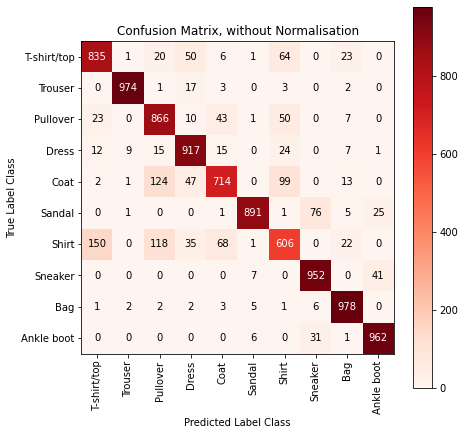

In [109]:
cm = metrics.confusion_matrix(test_label_tensor, predicted)

plt.figure(figsize=(7, 7))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Reds)
plt.colorbar() 

tick_marks = np.arange(len(class_name))
plt.xticks(tick_marks, class_name, rotation=90)
plt.yticks(tick_marks, class_name)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.title("Confusion Matrix, without Normalisation")
plt.xlabel("Predicted Label Class") 
plt.ylabel("True Label Class") 

plt.show()

### Save the model for later use.

In [32]:
torch.save(convNet.state_dict(), "convNet.pth")
print("Saved PyTorch Model State to convNet.pth")

Saved PyTorch Model State to convNet.pth
